In [1]:
from __future__ import division
from __future__ import print_function
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import pickle
import datetime
from IPython.display import HTML, display
from datetime import datetime
%matplotlib inline

# Homicide Data - Visualizations and Analysis
Using this definition https://www.fbi.gov/stats-services/publications/serial-murder#two, we know that a serial homicide deals with 2+ murdered victims and occur in separate events at different times. The goal of this notebook is to find visualize different combinations of murders in terms of victim and killer traits over time.  The first part of this notebook, we clean the data and get it ready.  The second part of this notebook, we use Folium to create simple maps of murder activity by state and city, and also use Seaborn to look at how murder compares to manslaughter, and weapon activity. Third, we begin to pick out some criteria that focus on unsolved murders and create a facet plot in Seaborn to visualize the trends in specific profiles of killings - like the increase/decrease of victims mal+ caucasian+18-24yo+killed by blunt object. 

# Data Cleaning

In [2]:
data = pd.read_csv("/Users/catherineordun/Documents/scripts/data/database.csv")

/Users/catherineordun/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print("There are", len(data), "records.")

There are 638454 records.


This is a nicely sized dataset with 638,454 records, consisting of 18 object variables and 6 integer variables a total of 24 variables. 

In [4]:
print(data.dtypes.value_counts())
print(data.dtypes)

object    18
int64      6
dtype: int64
Record ID                 int64
Agency Code              object
Agency Name              object
Agency Type              object
City                     object
State                    object
Year                      int64
Month                    object
Incident                  int64
Crime Type               object
Crime Solved             object
Victim Sex               object
Victim Age                int64
Victim Race              object
Victim Ethnicity         object
Perpetrator Sex          object
Perpetrator Age          object
Perpetrator Race         object
Perpetrator Ethnicity    object
Relationship             object
Weapon                   object
Victim Count              int64
Perpetrator Count         int64
Record Source            object
dtype: object


In [5]:
print(data.head())

   Record ID Agency Code Agency Name       Agency Type       City   State  \
0          1     AK00101   Anchorage  Municipal Police  Anchorage  Alaska   
1          2     AK00101   Anchorage  Municipal Police  Anchorage  Alaska   
2          3     AK00101   Anchorage  Municipal Police  Anchorage  Alaska   
3          4     AK00101   Anchorage  Municipal Police  Anchorage  Alaska   
4          5     AK00101   Anchorage  Municipal Police  Anchorage  Alaska   

   Year    Month  Incident              Crime Type      ...       \
0  1980  January         1  Murder or Manslaughter      ...        
1  1980    March         1  Murder or Manslaughter      ...        
2  1980    March         2  Murder or Manslaughter      ...        
3  1980    April         1  Murder or Manslaughter      ...        
4  1980    April         2  Murder or Manslaughter      ...        

  Victim Ethnicity Perpetrator Sex  Perpetrator Age  \
0          Unknown            Male               15   
1          Unknown

It would be a great to get a sense of size of the unique variables for each of those 18 object variables.  Let's get the unique category names of each object variable.  

In [6]:
print("Number unique Agency Name vars", data['Agency Name'].nunique())
print("Number unique Agency Code vars", data['Agency Code'].nunique())
print("Number unique Agency Type vars", data['Agency Type'].nunique())
print("Number unique City", data['City'].nunique())
print("Number unique State", data['State'].nunique())
print("Number unique Month", data['Month'].nunique())
print("Number unique Crime Type", data['Crime Type'].nunique())
print("Number unique Crime Solved", data['Crime Solved'].nunique())
print("Number unique Victim Sex", data['Victim Sex'].nunique())
print("Number unique Victim Ethnicity", data['Victim Ethnicity'].nunique())
print("Number unique Perpetrator Sex", data['Perpetrator Sex'].nunique())
print("Number unique Perpetrator Age", data['Perpetrator Age'].nunique())
print("Number unique Perpetrator Race", data['Perpetrator Race'].nunique())
print("Number unique Relationship", data['Relationship'].nunique())
print("Number unique Weapon", data['Weapon'].nunique())
print("Number unique Record Source", data['Record Source'].nunique())


Number unique Agency Name vars 9216
Number unique Agency Code vars 12003
Number unique Agency Type vars 7
Number unique City 1782
Number unique State 51
Number unique Month 12
Number unique Crime Type 2
Number unique Crime Solved 2
Number unique Victim Sex 3
Number unique Victim Ethnicity 3
Number unique Perpetrator Sex 3
Number unique Perpetrator Age 191
Number unique Perpetrator Race 5
Number unique Relationship 28
Number unique Weapon 16
Number unique Record Source 2


This is helpful because it gives us the sense of which features need to be formatted like 'Perpetrator Age' which we need to convert to int, which could be used as target variables like 'Victim Sex', 'Crime Type', 'Crime Solved', and which ones may not give us a lot of feature importance like 'Agency Code'. Let's get started.  

Let's take a look at a few random records just to get a sense of what the data looks like in a different format as opposed to the 'head' view. Let's look at Record ID 3 and 5000, below. 

In [7]:
print(data.loc[2])

Record ID                                            3
Agency Code                                    AK00101
Agency Name                                  Anchorage
Agency Type                           Municipal Police
City                                         Anchorage
State                                           Alaska
Year                                              1980
Month                                            March
Incident                                             2
Crime Type                      Murder or Manslaughter
Crime Solved                                        No
Victim Sex                                      Female
Victim Age                                          30
Victim Race              Native American/Alaska Native
Victim Ethnicity                               Unknown
Perpetrator Sex                                Unknown
Perpetrator Age                                      0
Perpetrator Race                               Unknown
Perpetrato

In [8]:
print(data.loc[4999])

Record ID                                  5000
Agency Code                             CT00158
Agency Name                            Westport
Agency Type                    Municipal Police
City                                  Fairfield
State                               Connecticut
Year                                       1980
Month                                   October
Incident                                      1
Crime Type               Murder or Manslaughter
Crime Solved                                Yes
Victim Sex                                 Male
Victim Age                                   21
Victim Race                               White
Victim Ethnicity                        Unknown
Perpetrator Sex                            Male
Perpetrator Age                              26
Perpetrator Race                          White
Perpetrator Ethnicity                   Unknown
Relationship                           Stranger
Weapon                                  

In [9]:
print(data.loc[99999])

Record ID                                100000
Agency Code                             TX12300
Agency Name                           Jefferson
Agency Type                             Sheriff
City                                  Jefferson
State                                     Texas
Year                                       1984
Month                                   October
Incident                                      1
Crime Type               Murder or Manslaughter
Crime Solved                                Yes
Victim Sex                                 Male
Victim Age                                   33
Victim Race                               White
Victim Ethnicity                   Not Hispanic
Perpetrator Sex                            Male
Perpetrator Age                              22
Perpetrator Race                          White
Perpetrator Ethnicity              Not Hispanic
Relationship                             Friend
Weapon                                  

In these three cases, we notice that there will be cases of 'unknown' as categories.  Undoubtedly, this will raise its head again and it'll be important to understand how many 'unknowns' exist.  Also, 'Perpetrator Age' isn't always indicated, for Case ID 3 it was 0, so there will be instances where probably 0 = unknown, as well.  Let's first do some cleansing. 

<li> Change Year to datetime
<li> Convert to categorical: 'Agency Type', 'State', 'Month', 'Crime Type', 'Crime Solved', 'Victim Sex', 'Victim Race', 'Victim Ethnicity', 'Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Ethnicity', 'Relationship', 'Weapon', 'Record Source'
<li> Convert 'Perpetrator Age' to integer

In [10]:
data2 = data.copy()

In [11]:
data2['Year'] = data2['Year'].astype(str)
data2['Month'] = data2['Month'].astype(str)
print(data2['Year'].unique())
print(data2['Month'].unique())

['1980' '1981' '1982' '1983' '1984' '1985' '1986' '1987' '1988' '1989'
 '1990' '1991' '1992' '1993' '1994' '1995' '1996' '1997' '1998' '1999'
 '2000' '2001' '2002' '2003' '2004' '2005' '2006' '2007' '2008' '2009'
 '2010' '2011' '2012' '2013' '2014']
['January' 'March' 'April' 'May' 'June' 'July' 'August' 'December'
 'November' 'February' 'October' 'September']


In [12]:
data2['Date'] = data2['Month'] + " "+ data2['Year']
print(data2.head())

   Record ID Agency Code Agency Name       Agency Type       City   State  \
0          1     AK00101   Anchorage  Municipal Police  Anchorage  Alaska   
1          2     AK00101   Anchorage  Municipal Police  Anchorage  Alaska   
2          3     AK00101   Anchorage  Municipal Police  Anchorage  Alaska   
3          4     AK00101   Anchorage  Municipal Police  Anchorage  Alaska   
4          5     AK00101   Anchorage  Municipal Police  Anchorage  Alaska   

   Year    Month  Incident              Crime Type      ...       \
0  1980  January         1  Murder or Manslaughter      ...        
1  1980    March         1  Murder or Manslaughter      ...        
2  1980    March         2  Murder or Manslaughter      ...        
3  1980    April         1  Murder or Manslaughter      ...        
4  1980    April         2  Murder or Manslaughter      ...        

  Perpetrator Sex Perpetrator Age               Perpetrator Race  \
0            Male              15  Native American/Alaska Na

In [13]:
#Convert the date into a single month-year
data2['Date'] = data2['Month'] + " " + data2['Year']
data2['Date_'] =  pd.to_datetime(data2['Date'], format='%B %Y')


In [14]:
print(data2.dtypes)

Record ID                         int64
Agency Code                      object
Agency Name                      object
Agency Type                      object
City                             object
State                            object
Year                             object
Month                            object
Incident                          int64
Crime Type                       object
Crime Solved                     object
Victim Sex                       object
Victim Age                        int64
Victim Race                      object
Victim Ethnicity                 object
Perpetrator Sex                  object
Perpetrator Age                  object
Perpetrator Race                 object
Perpetrator Ethnicity            object
Relationship                     object
Weapon                           object
Victim Count                      int64
Perpetrator Count                 int64
Record Source                    object
Date                             object


In [15]:
#Make sure it converted to only year datetimes
data2['Date_'].loc[:10]

0    1980-01-01
1    1980-03-01
2    1980-03-01
3    1980-04-01
4    1980-04-01
5    1980-05-01
6    1980-05-01
7    1980-06-01
8    1980-06-01
9    1980-06-01
10   1980-07-01
Name: Date_, dtype: datetime64[ns]

In [16]:
#Convert variables into categories 

def ascategory(cols, df):
	for col in cols:
		df[col] = df[col].astype('category')
all_cols = ['Agency Type',
            'State',
            'Month',
            'Crime Type', 
            'Crime Solved', 
            'Victim Sex', 'Victim Race', 
            'Victim Ethnicity', 
            'Perpetrator Sex', 
            'Perpetrator Race', 
            'Perpetrator Ethnicity', 
            'Relationship', 
            'Weapon',
            'Record Source'
]

ascategory(all_cols, data2)
print(data2.dtypes)

Record ID                         int64
Agency Code                      object
Agency Name                      object
Agency Type                    category
City                             object
State                          category
Year                             object
Month                          category
Incident                          int64
Crime Type                     category
Crime Solved                   category
Victim Sex                     category
Victim Age                        int64
Victim Race                    category
Victim Ethnicity               category
Perpetrator Sex                category
Perpetrator Age                  object
Perpetrator Race               category
Perpetrator Ethnicity          category
Relationship                   category
Weapon                         category
Victim Count                      int64
Perpetrator Count                 int64
Record Source                  category
Date                             object


Sometimes converting objects to integers takes a little investigation.  First, let's see what the unique values are and if there are any 'nans' or ' ' spaces. We can see that there are some values that are blank indicated by the ' '.  So, we need to first convert the whole object variable into a string, then replace the spaces with the character '0' zero, and then cast into an integer. I'm checking the head of the df and dtypes along the way to make sure it's working. 

In [17]:
data2['Perpetrator Age'].unique()

array([15, 42, 0, 36, 27, 35, 40, 49, 39, 29, 19, 23, 33, 26, 41, 28, 61,
       25, 7, 17, 34, 21, 43, 38, 66, 32, 37, 22, 30, 24, 65, 51, 60, 45,
       64, 18, 20, 44, 73, 62, 69, 52, 16, 90, 56, 47, 57, 31, 46, 14, 55,
       50, 54, 68, 77, 53, 67, 48, 76, 58, 71, 63, 89, 13, 75, 72, 93, 59,
       10, 11, 79, 74, 99, 70, 78, 80, 9, 12, 81, 6, 87, 82, 83, 8, 84, 85,
       86, 5, 3, 1, 88, 95, 4, 91, 92, 96, 94, 2, 98, 97, '22', '52', '21',
       '0', '25', '61', '32', '28', '20', '38', '18', '17', '53', '30',
       '24', '84', '43', '16', '47', '54', '50', '42', '23', '36', '35',
       '60', '27', '19', '14', '57', '63', '81', '31', '58', '51', '15',
       '40', '33', '26', '41', '29', '34', '37', '69', '44', '48', '55',
       '49', '56', '39', '45', '65', '59', '70', '46', '11', '77', '67',
       '76', '85', '72', '13', '89', '74', '71', '64', '62', '3', '80',
       '73', '75', '83', '78', '68', '66', '86', '87', '95', '90', '6',
       '12', '99', '88', '9', '93', '10', 

In [18]:
data2.head(5)

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source,Date,Date_
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI,January 1980,1980-01-01
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI,March 1980,1980-03-01
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI,March 1980,1980-03-01
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI,April 1980,1980-04-01
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI,April 1980,1980-04-01


In [19]:
data2['Perpetrator Age'] = data2['Perpetrator Age'].astype(str)
data2['Perpetrator Age'] = data2['Perpetrator Age'].str.replace(' ', '0')
print(data2.dtypes)

Record ID                         int64
Agency Code                      object
Agency Name                      object
Agency Type                    category
City                             object
State                          category
Year                             object
Month                          category
Incident                          int64
Crime Type                     category
Crime Solved                   category
Victim Sex                     category
Victim Age                        int64
Victim Race                    category
Victim Ethnicity               category
Perpetrator Sex                category
Perpetrator Age                  object
Perpetrator Race               category
Perpetrator Ethnicity          category
Relationship                   category
Weapon                         category
Victim Count                      int64
Perpetrator Count                 int64
Record Source                  category
Date                             object


In [20]:
data2['Perpetrator Age'].unique()

array(['15', '42', '0', '36', '27', '35', '40', '49', '39', '29', '19',
       '23', '33', '26', '41', '28', '61', '25', '7', '17', '34', '21',
       '43', '38', '66', '32', '37', '22', '30', '24', '65', '51', '60',
       '45', '64', '18', '20', '44', '73', '62', '69', '52', '16', '90',
       '56', '47', '57', '31', '46', '14', '55', '50', '54', '68', '77',
       '53', '67', '48', '76', '58', '71', '63', '89', '13', '75', '72',
       '93', '59', '10', '11', '79', '74', '99', '70', '78', '80', '9',
       '12', '81', '6', '87', '82', '83', '8', '84', '85', '86', '5', '3',
       '1', '88', '95', '4', '91', '92', '96', '94', '2', '98', '97'], dtype=object)

In [21]:
data2['Perpetrator Age'] = data2['Perpetrator Age'].astype(int)

In [22]:
data2.dtypes

Record ID                         int64
Agency Code                      object
Agency Name                      object
Agency Type                    category
City                             object
State                          category
Year                             object
Month                          category
Incident                          int64
Crime Type                     category
Crime Solved                   category
Victim Sex                     category
Victim Age                        int64
Victim Race                    category
Victim Ethnicity               category
Perpetrator Sex                category
Perpetrator Age                   int64
Perpetrator Race               category
Perpetrator Ethnicity          category
Relationship                   category
Weapon                         category
Victim Count                      int64
Perpetrator Count                 int64
Record Source                  category
Date                             object


# Descriptive Analysis and Maps

<b>Create a chloropleth to visualize the counts of each type of Crime Type, Incident, Victim Count, Prepetrator Count, by State:</b>

<b>From the map_data, let's get an understanding of the distribution of two crime types by state to answer the question: How many Murder or Manslaughter for each state? How many Manslaughter by Negligence for each state? </b>

In [24]:
map_counts = pd.pivot_table(data2,index=["State"],values=["Record ID"],aggfunc=[len])
#reshape
mc1 = map_counts.reset_index()
mc1.columns.droplevel()
mc1.columns = ['State', 'Total']
mc1.head()

,State,Total
0,Alabama,11376
1,Alaska,1617
2,Arizona,12871
3,Arkansas,6947
4,California,99783


In [25]:
map_crime = pd.pivot_table(data2,index=["State", "Crime Type"],values=["Record ID"],aggfunc=[len])
map_crime.head()

len
                                   Record ID
State   Crime Type                          
Alabama Manslaughter by Negligence        45
        Murder or Manslaughter         11331
Alaska  Manslaughter by Negligence       123
        Murder or Manslaughter          1494
Arizona Manslaughter by Negligence       364

In [26]:
#reshape a little so Seaborn can read
mc2 = map_crime.reset_index()
mc2.columns = mc2.columns.droplevel()
mc2.columns = ['State', 'Crime Type', 'Count']
mc2['crime'] = pd.factorize(mc2['Crime Type'])[0]
mc2.head()

,State,Crime Type,Count,crime
0,Alabama,Manslaughter by Negligence,45,0
1,Alabama,Murder or Manslaughter,11331,1
2,Alaska,Manslaughter by Negligence,123,0
3,Alaska,Murder or Manslaughter,1494,1
4,Arizona,Manslaughter by Negligence,364,0


<b>Which states have the greatest number of 'Murder or Manslaughter', purely based on counts of records? </b>

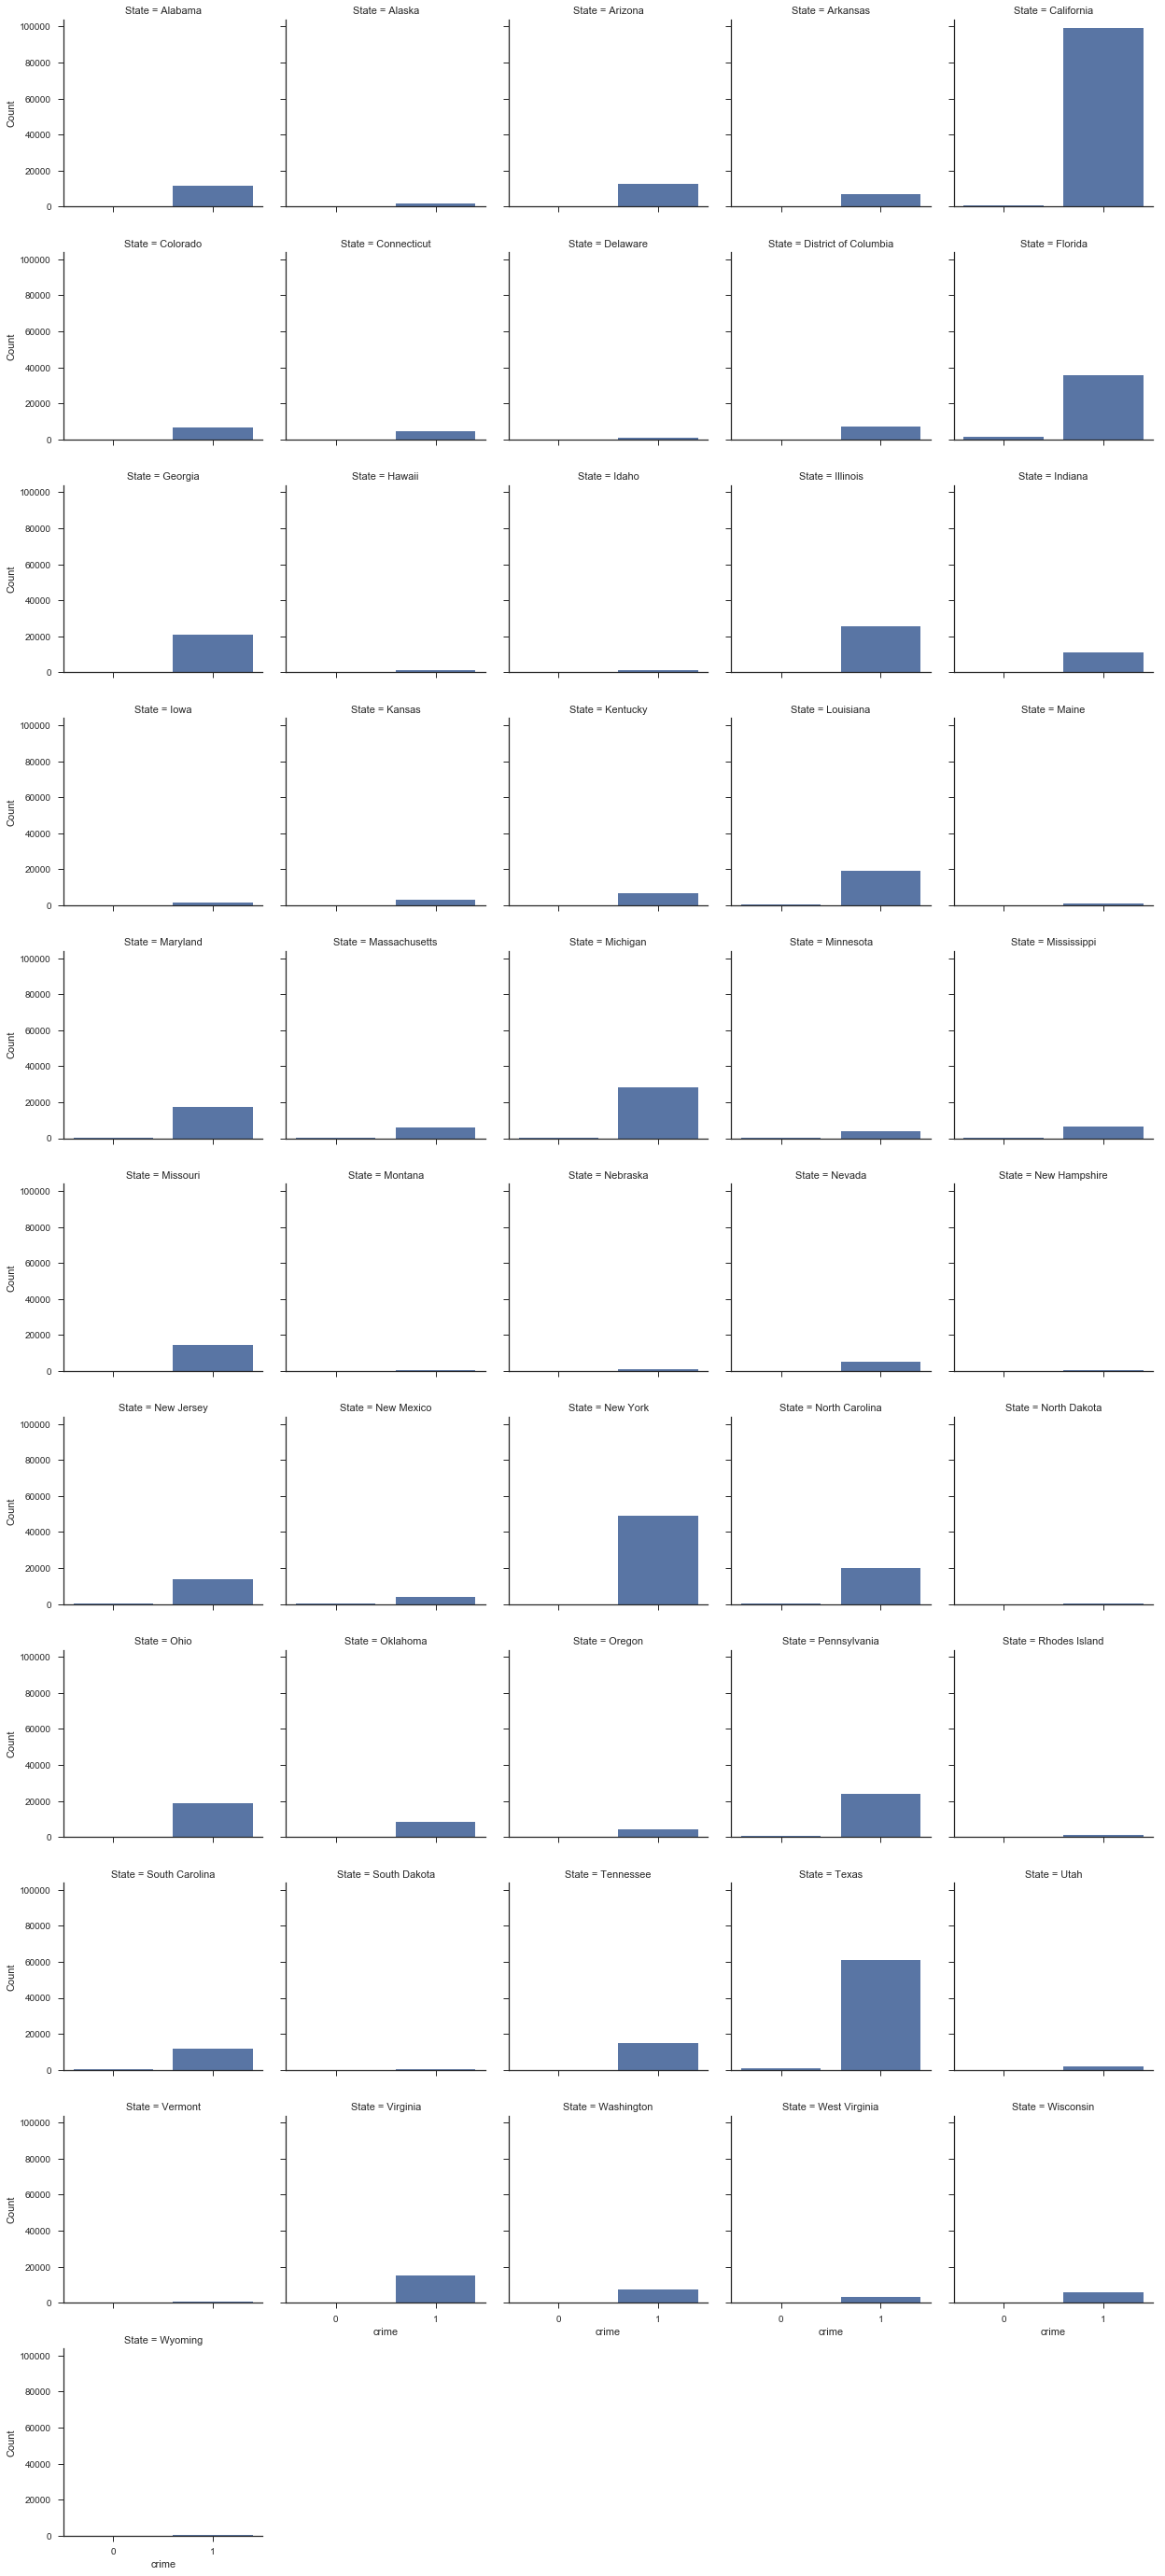

In [27]:
sns.set(style="ticks")
g = sns.FacetGrid(mc2, col="State", col_wrap=5, size=3.5)
g = g.map(sns.barplot, "crime", "Count")

In [28]:
crimecount = pd.merge(mc2, mc1, on='State')
crimecount['perc'] = crimecount['Count'] / crimecount['Total']
crimecount.head()

,State,Crime Type,Count,crime,Total,perc
0,Alabama,Manslaughter by Negligence,45,0,11376,0.003956
1,Alabama,Murder or Manslaughter,11331,1,11376,0.996044
2,Alaska,Manslaughter by Negligence,123,0,1617,0.076067
3,Alaska,Murder or Manslaughter,1494,1,1617,0.923933
4,Arizona,Manslaughter by Negligence,364,0,12871,0.028281


<b>How does'Murder or Manslaughter', compare to 'Manslaughter by Negligence', for each state based on the total percentage of all records during this time frame? </b> 

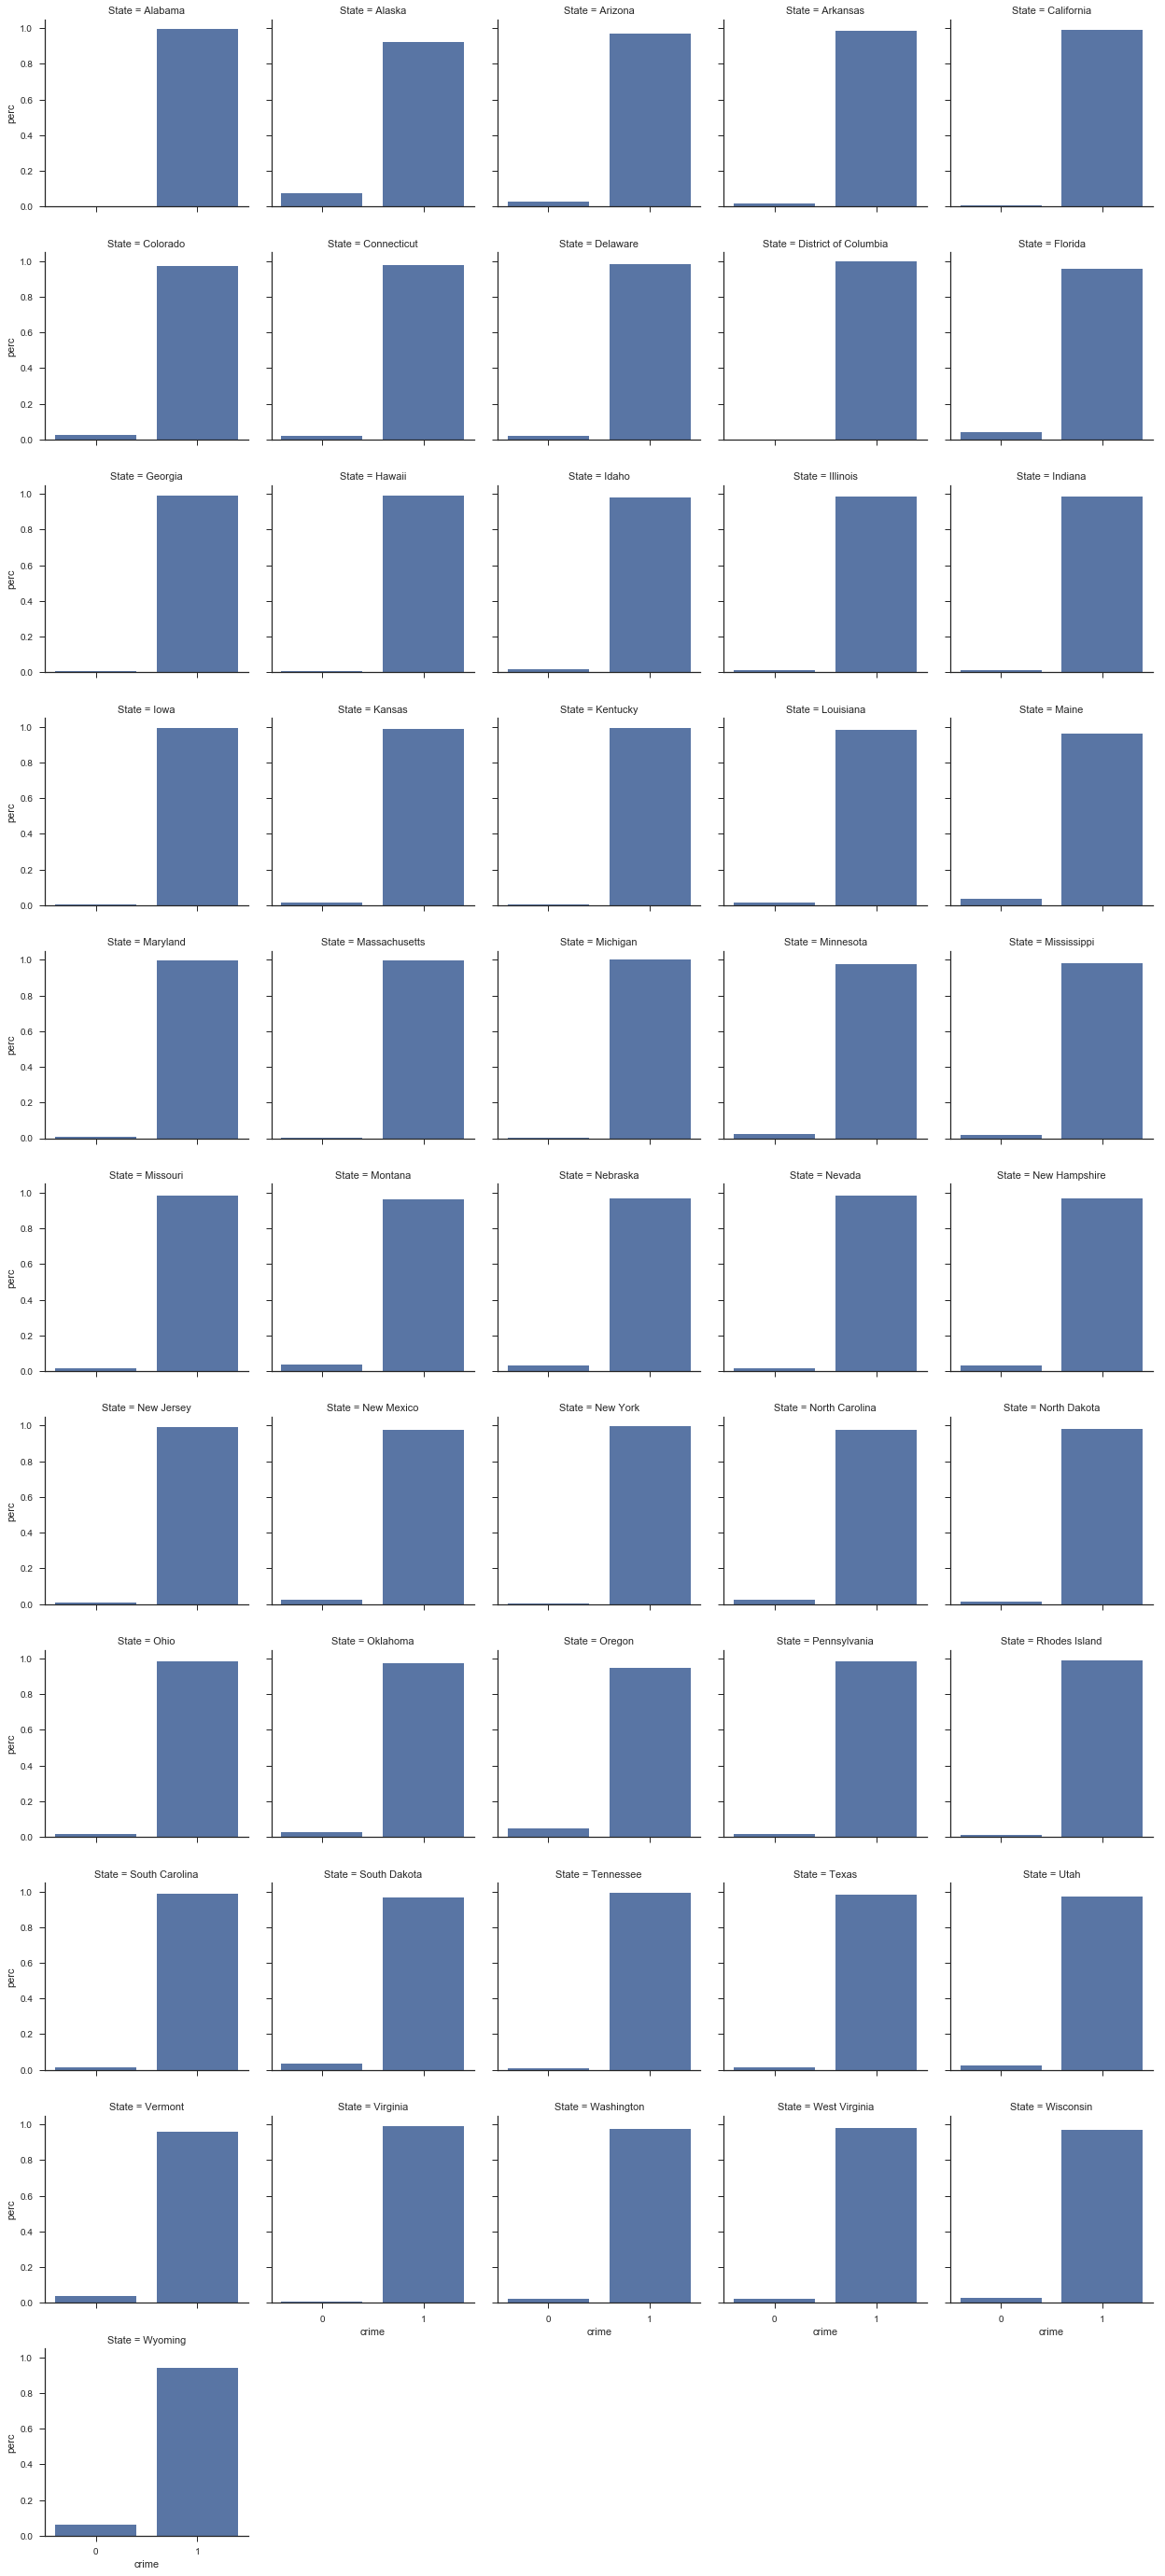

In [29]:
sns.set(style="ticks")
g = sns.FacetGrid(crimecount, col="State", col_wrap=5, size=3.5)
g = g.map(sns.barplot, "crime", "perc")


<b>Top States for Murder</b>

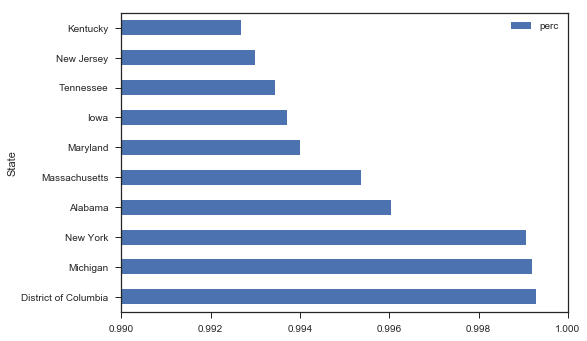

In [36]:
(((crimecount.loc[(crimecount['crime']==1)]).sort_values(by='perc', ascending=False)).head(10)).plot(x='State', y='perc', kind='barh', xlim = (.99, 1.0))

<b> Top Cities for Murder </b>

In [37]:
city_crime = pd.pivot_table(data2,index=["State", "City", "Crime Type"],values=["Record ID"],aggfunc=[len])
#reshape a little so Seaborn can read
cc = city_crime.reset_index()
cc.columns = cc.columns.droplevel()
cc.columns = ['State', 'City', 'Crime Type', 'Count']
cc['crime'] = pd.factorize(cc['Crime Type'])[0]
cc.head()

,State,City,Crime Type,Count,crime
0,Alabama,Abbeville,Manslaughter by Negligence,NaN,0
1,Alabama,Abbeville,Murder or Manslaughter,NaN,1
2,Alabama,Acadia,Manslaughter by Negligence,NaN,0
3,Alabama,Acadia,Murder or Manslaughter,NaN,1
4,Alabama,Accomack,Manslaughter by Negligence,NaN,0


In [38]:
state_totals = pd.pivot_table(data2,index=["State"],values=["Record ID"],aggfunc=[len])
#reshape
tot = state_totals.reset_index()
tot.columns.droplevel()
tot.columns = ['State', 'Total']
tot.dtypes

cc_fin = pd.merge(cc, tot, on='State', how='left')
cc_fin['perc'] = cc_fin['Count'] / cc_fin['Total']
cc_fin.head()

,State,City,Crime Type,Count,crime,Total,perc
0,Alabama,Abbeville,Manslaughter by Negligence,NaN,0,11376,NaN
1,Alabama,Abbeville,Murder or Manslaughter,NaN,1,11376,NaN
2,Alabama,Acadia,Manslaughter by Negligence,NaN,0,11376,NaN
3,Alabama,Acadia,Murder or Manslaughter,NaN,1,11376,NaN
4,Alabama,Accomack,Manslaughter by Negligence,NaN,0,11376,NaN


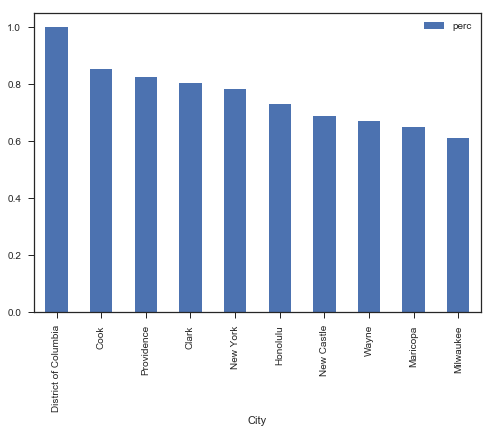

In [164]:
#Top 10 cities by percentage of all crimes as crime type "Murder or Manslaughter"
cities = (cc_fin.loc[(cc_fin['crime']==1)])
((cities.sort_values(by='perc', ascending=False)).head(10)).plot(x='City', y='perc', kind='bar')

<b> Let's explore the weapons and any trends in how they've been used in crimes has changed from year to year. </b>

In [39]:
crime_time = pd.pivot_table(data2,index=["Year", "Weapon"],values=["Record ID"],aggfunc=[len])

In [40]:
crime_time.reset_index(inplace=True)
crime_time.columns.droplevel()
crime_time.columns = ['Year', 'Weapon', 'Count']
crime_time.dtypes

Year        object
Weapon    category
Count      float64
dtype: object

In [41]:
crime_time['Year'] = pd.factorize(crime_time['Year'])[0]
crime_time.head()

,Year,Weapon,Count
0,0,Blunt Object,2397.0
1,0,Drowning,50.0
2,0,Drugs,14.0
3,0,Explosives,22.0
4,0,Fall,17.0


Factor Plot to show use of weapons over time

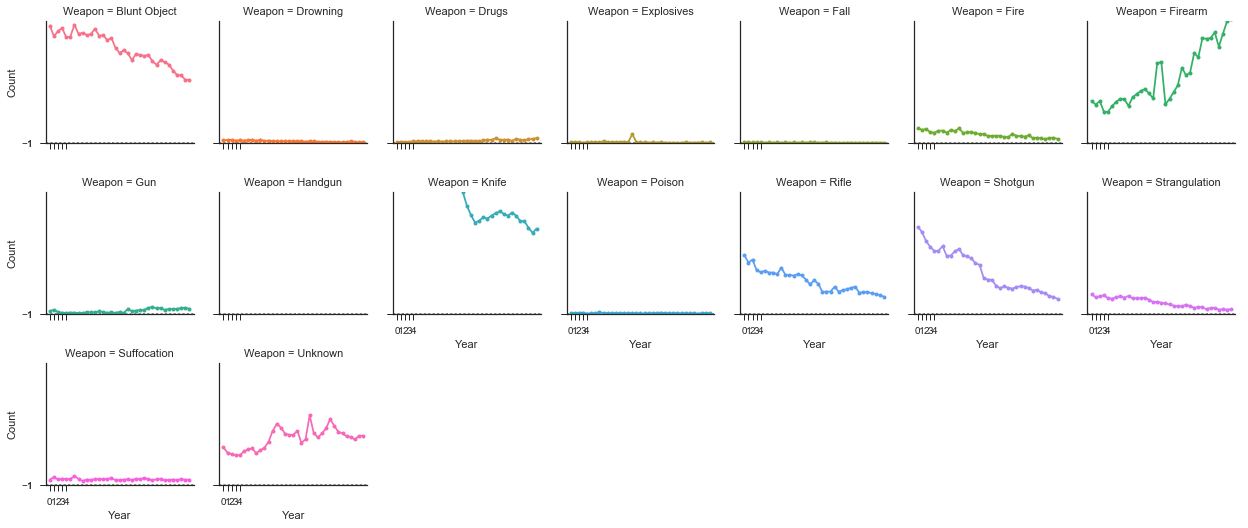

In [42]:
# Create a dataset with many short random walks
rs = np.random.RandomState(4)
pos = rs.randint(-1, 2, (20, 5)).cumsum(axis=1)
pos -= pos[:, 0, np.newaxis]
step = np.tile(range(5), 20)
walk = np.repeat(range(20), 5)

sns.set(style="ticks")
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(crime_time, col="Weapon", hue="Weapon", col_wrap=7, size=2.5)

# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=.5, ls=":", c=".5")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "Year", "Count", marker="o", ms=4)

# Adjust the tick positions and labels
#xlim is the years factorized from 0 to 34 
grid.set(xticks=np.arange(5), yticks=[-1, 1],
         xlim=(-1, 35), ylim=(0, 2500))

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1.15)


Use of firearms as a weapon has steadily increased form 1980 to 2014, and notice how 'Gun' has also increased, which should really be rolled up into 'Firearm'. Weapons like 'Rifle' and 'Shotgun' should also be folded under 'Firearm' possibly. But, we can see that the number of crimes committed using 'Knife' and 'Blunt Object' are high in count.  The 'Unknown' weapon type has also increased over the years. 


# Coding different combinations

It makes sense that solved crimes with known perpetrators (sex, age, ethnicity, race) are not serial killers still at-large.  After narrowing down the population to unsolved cases, we could create a "profile" code of different combinations of victim sex-age-race-ethnicity-age and identify which codes have been repeated several times across time and also across nearby geographic cities. This may give us a sense of repetitive patterns of murders, where certain profiles of victims have been killed in the same way.  

Let's outline some basic criteria where we'd like to focus on a subset of data that has these features: 

<li> Crime == Not solved
<li> Crime == Murder or Manslaughter
<li> Perpetrator Sex, Age, Race, Ethnicity == Unknown
<li> Relationship == Unknown
<li> Weapon could be any type
<li> Victim Count could be any number

With these conditions met, we can create a population of unsolved crimes to focus on. 

In [43]:
data2['Crime Solved'].unique()

[Yes, No]
Categories (2, object): [Yes, No]

In [44]:
data2['Crime Solved'] = data2['Crime Solved'].map({'Yes': 1, 'No':0})

In [45]:
data2['Crime Type'] = data2['Crime Type'].map({'Murder or Manslaughter': 1, 'Manslaughter by Negligence':0})

In [46]:
print(data2['Perpetrator Sex'].unique())
print(data2['Perpetrator Age'].unique())
print(data2['Perpetrator Race'].unique())
print(data2['Perpetrator Ethnicity'].unique())

[Male, Unknown, Female]
Categories (3, object): [Male, Unknown, Female]
[15 42  0 36 27 35 40 49 39 29 19 23 33 26 41 28 61 25  7 17 34 21 43 38 66
 32 37 22 30 24 65 51 60 45 64 18 20 44 73 62 69 52 16 90 56 47 57 31 46 14
 55 50 54 68 77 53 67 48 76 58 71 63 89 13 75 72 93 59 10 11 79 74 99 70 78
 80  9 12 81  6 87 82 83  8 84 85 86  5  3  1 88 95  4 91 92 96 94  2 98 97]
[Native American/Alaska Native, White, Unknown, Black, Asian/Pacific Islander]
Categories (5, object): [Native American/Alaska Native, White, Unknown, Black, Asian/Pacific Islander]
[Unknown, Not Hispanic, Hispanic]
Categories (3, object): [Unknown, Not Hispanic, Hispanic]


In [47]:
data2['meets_criteria'] = np.where(((data2['Crime Solved'] == 0) & 
                                   (data2['Crime Type'] == 1) &
                                   (data2['Perpetrator Sex'] == 'Unknown') &
                                   (data2['Perpetrator Age'] ==0) &
                                   (data2['Perpetrator Race'] == 'Unknown') &
                                   (data2['Perpetrator Ethnicity'] =='Unknown')),
                                   1, 0)
print(len((data2.loc[(data2['meets_criteria']== 1)])))

188835


In [48]:
print("This is", (len((data2.loc[(data2['meets_criteria']== 1)]))) / len(data2), "of the total cases.")

This is 0.295769154865 of the total cases.


Almost 30% of the cases meet our criteria, where the crime was not solved and the perpetrator was unknown. Let's drill into this set of the population to write a detection model. Let's start with some exploration of this population. Let's start by year and then by year and city. 

In [49]:
pop = (data2.loc[(data2['meets_criteria']== 1)])

In [50]:
pop.describe()

,Record ID,Incident,Crime Type,Crime Solved,Victim Age,Perpetrator Age,Victim Count,Perpetrator Count,meets_criteria
count,188835.000000,188835.000000,188835.0,188835.0,188835.000000,188835.0,188835.000000,188835.000000,188835.0
mean,325925.152615,25.377118,1.0,0.0,37.442757,0.0,0.101522,0.034369,1.0
std,180446.706058,87.727404,0.0,0.0,57.133447,0.0,0.431471,0.203199,0.0
min,3.000000,0.000000,1.0,0.0,0.000000,0.0,0.000000,0.000000,1.0
25%,175900.000000,1.000000,1.0,0.0,22.000000,0.0,0.000000,0.000000,1.0
50%,326415.000000,4.000000,1.0,0.0,29.000000,0.0,0.000000,0.000000,1.0
75%,481334.000000,16.000000,1.0,0.0,41.000000,0.0,0.000000,0.000000,1.0
max,638450.000000,999.000000,1.0,0.0,998.000000,0.0,9.000000,8.000000,1.0


<b> View Number of Unsolved Murders by Date </b>

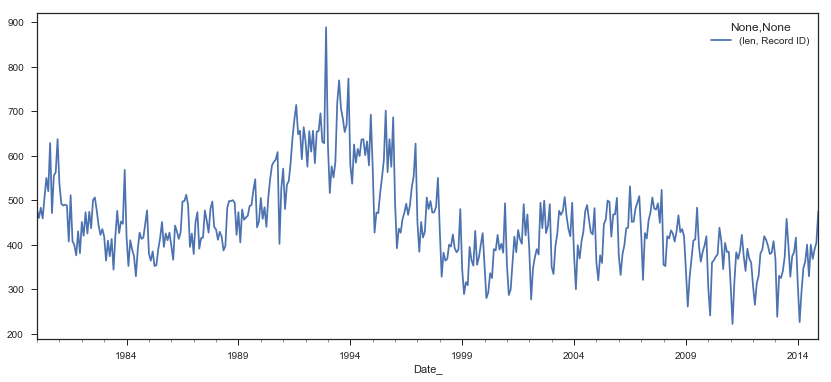

In [51]:
pop_time = (pd.pivot_table(pop,index=["Date_"],values=["Record ID"],aggfunc=[len]))
pop_time.plot(figsize=(14,6))

In [ ]:
pop_time.sort_values(('len', 'Record ID'), ascending=False).head(10)

<b>Fluctuation in crimes from city to city.</b>

In [52]:
pop_city = (pd.pivot_table(pop,index=["City"],
                           columns = "Year", 
                           values=["Record ID"],
                           aggfunc=lambda x: len(x)))
pop_city.fillna(value=0, inplace=True)
pop_city

Record ID                                                  \
Year                     1980  1981  1982  1983  1984  1985  1986  1987  1988   
City                                                                            
Abbeville                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Acadia                    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Accomack                  0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
Ada                       1.0   0.0   1.0   0.0   2.0   1.0   1.0   1.0   2.0   
Adair                     0.0   0.0   1.0   0.0   0.0   0.0   0.0   1.0   0.0   
Adams                     5.0   5.0   3.0   3.0   5.0   3.0   6.0   3.0   4.0   
Addison                   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Aiken                     0.0   0.0   4.0   2.0   2.0   0.0   0.0   1.0   1.0   
Alachua                   1.0   1.0   2.0   2.0   1.0   7.0   2.0   3.0   0.0   
Alamance                  2.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   
Alameda                  61.0  32.0  43.0  33.0  36.0  54.0  63.0  67.0  53.0   
Alamosa                   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
Albany                    0.0   1.0   3.0   0.0   0.0   1.0   4.0   2.0   3.0   
Albemarle                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
Alcona                    1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Alcorn                    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Alexander                 0.0   1.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   
Alexandria                1.0   2.0   0.0   0.0   2.0   0.0   3.0   2.0   1.0   
Alfalfa                   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
Allegan                   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   
Allegany                  0.0   3.0   0.0   2.0   1.0   0.0   1.0   1.0   0.0   
Allegheny                12.0  14.0  17.0  16.0  12.0   3.0   9.0   6.0   3.0   
Allen                     9.0   4.0   7.0   7.0   0.0  13.0   2.0   4.0  10.0   
Allendale                 0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Alpena                    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Alpine                    0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   
Amador                    0.0   0.0   0.0   0.0   0.0   0.0   1.0   3.0   0.0   
Amelia                    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Amherst                   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Amite                     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...                       ...   ...   ...   ...   ...   ...   ...   ...   ...   
Wolfe                     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Wood                      1.0   2.0   0.0   1.0   1.0   1.0   2.0   3.0   0.0   
Woodbury                  0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   
Woodford                  0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   
Woodruff                  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Woodson                   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   
Woodward                  0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   
Worcester                 4.0   4.0   3.0   3.0   5.0   2.0   1.0   4.0   0.0   
Worth                     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   
Wrangell-Petersburg       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Wyandot                   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Wyandotte                 4.0   6.0   6.0  11.0   8.0   4.0   6.0  10.0   0.0   
Wyoming                   0.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   
Wythe                     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Yadkin                    0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Yakima                    2.0   4.0   1.0   0.0   2

In [53]:
#normalized data frame across rows by their sums
df_norm = pop_city.div(pop_city.sum(axis=1), axis=0)

In [54]:
#compute the standard deviation for each row
df_norm['std'] = (df_norm.std(axis=1))

In [55]:
df_norm['mean'] = (df_norm.mean(axis=1))

In [56]:
df_norm.head()

Record ID                                                         \
Year           1980 1981      1982      1983      1984      1985      1986   
City                                                                         
Abbeville  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
Acadia     0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
Accomack   0.000000  0.0  0.000000  0.083333  0.000000  0.000000  0.000000   
Ada        0.052632  0.0  0.052632  0.000000  0.105263  0.052632  0.052632   
Adair      0.000000  0.0  0.058824  0.000000  0.000000  0.000000  0.000000   

                                           ...                         \
Year           1987      1988      1989    ...         2007      2008   
City                                       ...                          
Abbeville  0.000000  0.000000  0.000000    ...     0.000000  0.000000   
Acadia     0.000000  0.000000  0.000000    ...     0.000000  0.062500   
Accomack   0.000000  0.000000  0.000000    ...     0.083333  0.000000   
Ada        0.052632  0.105263  0.000000    ...     0.052632  0.000000   
Adair      0.058824  0.000000  0.058824    ...     0.000000  0.058824   

                                                                       \
Year           2009      2010      2011      2012      2013      2014   
City                                                                    
Abbeville  0.000000  0.000000  0.000000  0.000000  0.250000  0.000000   
Acadia     0.125000  0.000000  0.000000  0.125000  0.000000  0.000000   
Accomack   0.000000  0.083333  0.000000  0.083333  0.083333  0.166667   
Ada        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Adair      0.058824  0.000000  0.058824  0.058824  0.000000  0.058824   

                std      mean  
Year                           
City                           
Abbeville  0.080701  0.030019  
Acadia     0.051052  0.029196  
Accomack   0.044935  0.029026  
Ada        0.034590  0.028739  
Adair      0.041279  0.028924  

[5 rows x 37 columns]

In [71]:
#cities with more than one murder over the 2008 - 2014 year history
#1 murder over the time frame leads to a std of 0.169031
more_than_one = (df_norm.loc[(df_norm['std'] != 0.169031)])
more_than_one
#more_than_one.sort_values(by='std', ascending=False).head(10)
more_than_one.reset_index()

City Record ID                                          \
Year                           1980      1981      1982      1983      1984   
0               Abbeville  0.000000  0.000000  0.000000  0.000000  0.000000   
1                  Acadia  0.000000  0.000000  0.000000  0.000000  0.000000   
2                Accomack  0.000000  0.000000  0.000000  0.083333  0.000000   
3                     Ada  0.052632  0.000000  0.052632  0.000000  0.105263   
4                   Adair  0.000000  0.000000  0.058824  0.000000  0.000000   
5                   Adams  0.049505  0.049505  0.029703  0.029703  0.049505   
6                 Addison  0.000000  0.000000  0.000000  0.000000  0.000000   
7                   Aiken  0.000000  0.000000  0.088889  0.044444  0.044444   
8                 Alachua  0.016949  0.016949  0.033898  0.033898  0.016949   
9                Alamance  0.068966  0.000000  0.000000  0.000000  0.000000   
10                Alameda  0.024322  0.012759  0.017145  0.013158  0.014354   
11                Alamosa  0.000000  0.000000  0.000000  1.000000  0.000000   
12                 Albany  0.000000  0.012346  0.037037  0.000000  0.000000   
13              Albemarle  0.000000  0.000000  0.000000  0.000000  0.000000   
14                 Alcona  0.142857  0.000000  0.000000  0.000000  0.000000   
15                 Alcorn  0.000000  0.000000  0.000000  0.000000  0.000000   
16              Alexander  0.000000  0.200000  0.000000  0.000000  0.000000   
17             Alexandria  0.032258  0.064516  0.000000  0.000000  0.064516   
18                Alfalfa  0.000000  0.000000  0.000000  1.000000  0.000000   
19                Allegan  0.000000  0.000000  0.000000  0.000000  0.000000   
20               Allegany  0.000000  0.214286  0.000000  0.142857  0.071429   
21              Allegheny  0.012526  0.014614  0.017745  0.016701  0.012526   
22                  Allen  0.028939  0.012862  0.022508  0.022508  0.000000   
23              Allendale  0.000000  0.111111  0.000000  0.000000  0.000000   
24                 Alpena  0.000000  0.000000  0.000000  0.000000  0.000000   
25                 Alpine  0.000000  0.000000  0.000000  0.000000  1.000000   
26                 Amador  0.000000  0.000000  0.000000  0.000000  0.000000   
27                 Amelia  0.000000  0.000000  0.000000  0.000000  0.000000   
28                Amherst  0.000000  0.000000  0.000000  0.000000  0.000000   
29                  Amite  0.000000  0.000000  0.000000  0.000000  0.000000   
...                   ...       ...       ...       ...       ...       ...   
1467                Wolfe  0.000000  0.000000  0.000000  0.000000  0.000000   
1468                 Wood  0.028571  0.057143  0.000000  0.028571  0.028571   
1469             Woodbury  0.000000  0.000000  0.000000  0.100000  0.100000   
1470             Woodford  0.000000  0.000000  0.000000  0.000000  0.000000   
1471             Woodruff  0.000000  0.000000  0.000000  0.000000  0.000000   
1472              Woodson  0.000000  0.000000  0.000000  0.000000  0.000000   
1473             Woodward  0.000000  0.000000  0.500000  0.500000  0.000000   
1474            Worcester  0.039216  0.039216  0.029412  0.029412  0.049020   
1475                Worth  0.000000  0.000000  0.000000  0.000000  0.000000   
1476  Wrangell-Petersburg  0.000000  0.000000  0.000000  0.000000  0.000000   
1477              Wyandot  0.000000  0.000000  0.000000  0.000000  0.000000   
1478            Wyandotte  0.018868  0.028302  0.028302  0.051887  0.037736   
1479              Wyoming  0.000000  0.076923  0.000000  0.000000  0.076923   
1480                Wythe  0.000000  0.000000  0.000000  0.000000  0.000000   
1481               Yadkin  0.000000  0.166667  0.000000  0.000000  0.000000   
1482               Yakima  0.017857  0.035714  0.008929  0.000000  0.017857   
1483            Yalobusha  0.000000  0.000000  0.500000  0.250000  0.000000   
1484              Yamhill  0.000000  0.000000  0.000000  0.000000  0.00

## Coding Continued - Sex / Age / Race / Ethnicity / Weapon 

"Profiles" means a single code that combines the Victim Sex / Age / Race / Ethnicity / Weapon, by the City and Date.  At the end of this notebook, I create a plot that counts up the number of each of these unique codes grouped by the Sex and Age Group (binned).  The goal of this exercise is to set up "mini signals" of specific types of murders at the national level.  Later, (note in this notebook), my goal is to bring this down to the state level so that I can trace murders of different profiles from county to county quarter to quarter. 


In [12]:
pop_victim_combos_2 = pop[['Victim Sex', 'Victim Age', 'Victim Race', 'Victim Ethnicity', 'Date_', 'City', 'State', 'Weapon', 'Record ID']].copy()

In [13]:
pvc_2 = pop_victim_combos_2.groupby(['State', 'Date_', 'City', 'Weapon', 'Victim Sex', 'Victim Race','Victim Ethnicity', 'Victim Age']).size()

In [14]:
pvc_2.head(10)

State    Date_       City        Weapon      Victim Sex  Victim Race  Victim Ethnicity  Victim Age
Alabama  1980-01-01  Cleburne    Handgun     Female      White        Unknown           63            1
                                                                                        77            1
                                             Male        White        Unknown           79            1
                                                                                        99            1
                     Limestone   Handgun     Female      White        Unknown           27            1
                     Mobile      Handgun     Male        White        Unknown           29            1
                     Tuscaloosa  Firearm     Male        White        Unknown           55            1
                     Walker      Explosives  Female      White        Unknown           28            1
         1980-02-01  Mobile      Firearm     Male        White       

In [15]:
pvc_fin = pvc_2.reset_index()

In [16]:
pvc_fin.dtypes

State                     category
Date_               datetime64[ns]
City                        object
Weapon                    category
Victim Sex                category
Victim Race               category
Victim Ethnicity          category
Victim Age                   int64
0                            int64
dtype: object

In [17]:
pvc_fin.head()

,State,Date_,City,Weapon,Victim Sex,Victim Race,Victim Ethnicity,Victim Age,0
0,Alabama,1980-01-01,Cleburne,Handgun,Female,White,Unknown,63,1
1,Alabama,1980-01-01,Cleburne,Handgun,Female,White,Unknown,77,1
2,Alabama,1980-01-01,Cleburne,Handgun,Male,White,Unknown,79,1
3,Alabama,1980-01-01,Cleburne,Handgun,Male,White,Unknown,99,1
4,Alabama,1980-01-01,Limestone,Handgun,Female,White,Unknown,27,1


In [18]:
pvc_fin['City'] = pd.factorize(pvc_fin['City'])[0]
print(pvc_fin['City'].nunique())
pvc_fin['Weapon'] = pd.factorize(pvc_fin['Weapon'])[0]
print(pvc_fin['Weapon'].nunique())
pvc_fin['Victim Sex'] = pd.factorize(pvc_fin['Victim Sex'])[0]
print(pvc_fin['Victim Sex'].nunique())
pvc_fin['Victim Race'] = pd.factorize(pvc_fin['Victim Race'])[0]
print(pvc_fin['Victim Race'].nunique())
pvc_fin['Victim Ethnicity'] = pd.factorize(pvc_fin['Victim Ethnicity'])[0]
print(pvc_fin['Victim Ethnicity'].nunique())

1497
16
3
5
3


In [19]:
pvc_fin.head()

,State,Date_,City,Weapon,Victim Sex,Victim Race,Victim Ethnicity,Victim Age,0
0,Alabama,1980-01-01,0,0,0,0,0,63,1
1,Alabama,1980-01-01,0,0,0,0,0,77,1
2,Alabama,1980-01-01,0,0,1,0,0,79,1
3,Alabama,1980-01-01,0,0,1,0,0,99,1
4,Alabama,1980-01-01,1,0,0,0,0,27,1


<b>Set up codes for each record</b>

In [20]:
x= pvc_fin.groupby(['State', 'Date_', 'City', 'Weapon', 'Victim Sex', 'Victim Race','Victim Ethnicity', 'Victim Age']).size()
x_ = x.reset_index()
print(x_)

          State      Date_  City  Weapon  Victim Sex  Victim Race  \
0       Alabama 1980-01-01     0       0           0            0   
1       Alabama 1980-01-01     0       0           0            0   
2       Alabama 1980-01-01     0       0           1            0   
3       Alabama 1980-01-01     0       0           1            0   
4       Alabama 1980-01-01     1       0           0            0   
5       Alabama 1980-01-01     2       0           1            0   
6       Alabama 1980-01-01     3       1           1            0   
7       Alabama 1980-01-01     4       2           0            0   
8       Alabama 1980-02-01     2       1           1            0   
9       Alabama 1980-02-01     4       0           0            0   
10      Alabama 1980-03-01     2       0           1            0   
11      Alabama 1980-03-01     5       3           1            0   
12      Alabama 1980-03-01     6       4           1            1   
13      Alabama 1980-03-01     7  

In [21]:
x_df = x_.reset_index().groupby(['Weapon','Victim Sex', 'Victim Race', 'Victim Ethnicity', 'Victim Age', 'State', 'City', 'Date_'])['index'].apply(np.array)


In [22]:
xx_ = x_df.reset_index()

In [23]:
print(xx_.dtypes)

Weapon                       int64
Victim Sex                   int64
Victim Race                  int64
Victim Ethnicity             int64
Victim Age                   int64
State                       object
City                         int64
Date_               datetime64[ns]
index                       object
dtype: object


In [24]:
xx_['code'] = ((xx_['Weapon'].astype(str))+ (xx_['Victim Sex'].astype(str))+(xx_['Victim Race'].astype(str))+(xx_['Victim Sex'].astype(str))+ (xx_['Victim Ethnicity'].astype(str)))
print(xx_.head())

   Weapon  Victim Sex  Victim Race  Victim Ethnicity  Victim Age     State  \
0       0           0            0                 0           0   Florida   
1       0           0            0                 0           1   Florida   
2       0           0            0                 0           2  Kentucky   
3       0           0            0                 0           2  Kentucky   
4       0           0            0                 0           3    Nevada   

   City      Date_     index   code  
0   262 2000-02-01   [53892]  00000  
1   254 2001-12-01   [54277]  00000  
2   553 1990-09-01   [77658]  00000  
3   553 1990-12-01   [77684]  00000  
4   100 1984-06-01  [109153]  00000  


In [135]:
print(xx_)

        Weapon  Victim Sex  Victim Race  Victim Ethnicity  Victim Age  \
0            0           0            0                 0           0   
1            0           0            0                 0           1   
2            0           0            0                 0           2   
3            0           0            0                 0           2   
4            0           0            0                 0           3   
5            0           0            0                 0           3   
6            0           0            0                 0           3   
7            0           0            0                 0           5   
8            0           0            0                 0           5   
9            0           0            0                 0           5   
10           0           0            0                 0           6   
11           0           0            0                 0           6   
12           0           0            0            

Bin ages int six groups, examples for Males Only in this sample. 

In [110]:
#stratify into age groups

"""
list: 
age group 1 - Under 5
age group 2 - 5 - 17
age group 3 - Over 18 - 24
age group 4 - 25 - 44
age group 5 - 45 - 64
age group 6 - 65 and Over

"""
bins = [1, 5, 17, 24, 44, 64, 100]
group_names = ['ag1', 
'ag2', 
'ag3',
'ag4', 
'ag5',
'ag6']
#bins
xx_['age_group'] = pd.cut(xx_['Victim Age'], bins, labels=group_names)
pd.value_counts(xx_['age_group'])
#will need to do a separate analysis of Victim Age == 0, because these are likely unknowns

ag4    81730
ag3    44780
ag5    24809
ag6    13128
ag2     9915
ag1      815
Name: age_group, dtype: int64

<b>Analyze by Sex - Clusters of Codes </b>

In [41]:
#male codes
xx_codes_m = xx_.loc[(xx_['Victim Sex'] ==1)]
print(len(xx_codes_m))
#female codes
xx_codes_f = xx_.loc[(xx_['Victim Sex'] ==0)]
print(len(xx_codes_f))

144079
32563


In [ ]:
#test1 = test.loc[(test['Victim Age'] ==0)]
#run this to get all the codes for victims of unknown age

<b>Male Murders: Age Group 1 - 1 to 5 years old (toddlers)</b>

In [111]:
#male codes
m_analyze = xx_codes_m[['State', 'City', 'code', 'Date_', 'age_group']].copy()
m1 = m_analyze.loc[(m_analyze['age_group'] == 'ag1')&(m_analyze['State'] == 'New York')]
m1.head()

,State,City,code,Date_,age_group
8576,New York,908,01010,1990-04-01,ag1
8577,New York,908,01010,1992-03-01,ag1
8578,New York,908,01010,1996-06-01,ag1
8584,New York,908,01010,2004-05-01,ag1
8589,New York,908,01010,1993-06-01,ag1


In [112]:
pvt = pd.pivot_table(m1,index=["Date_", "City", "code"],values=["State"],aggfunc=lambda x: len(x))
pvt1 = pvt.reset_index()
pvt1

,Date_,City,code,State
0,1980-04-01,914,91010,1
1,1980-06-01,359,41010,1
2,1980-12-01,908,41010,1
3,1982-02-01,908,41110,1
4,1983-09-01,908,41110,1
5,1983-10-01,908,41110,1
6,1983-12-01,908,41110,1
7,1984-01-01,908,41111,1
8,1984-04-01,908,01012,3
9,1984-04-01,908,01110,1


In [113]:
pvt1['newdate'] = pd.factorize(pvt1['Date_'])[0]
pvt1

,Date_,City,code,State,newdate
0,1980-04-01,914,91010,1,0
1,1980-06-01,359,41010,1,1
2,1980-12-01,908,41010,1,2
3,1982-02-01,908,41110,1,3
4,1983-09-01,908,41110,1,4
5,1983-10-01,908,41110,1,5
6,1983-12-01,908,41110,1,6
7,1984-01-01,908,41111,1,7
8,1984-04-01,908,01012,3,8
9,1984-04-01,908,01110,1,8


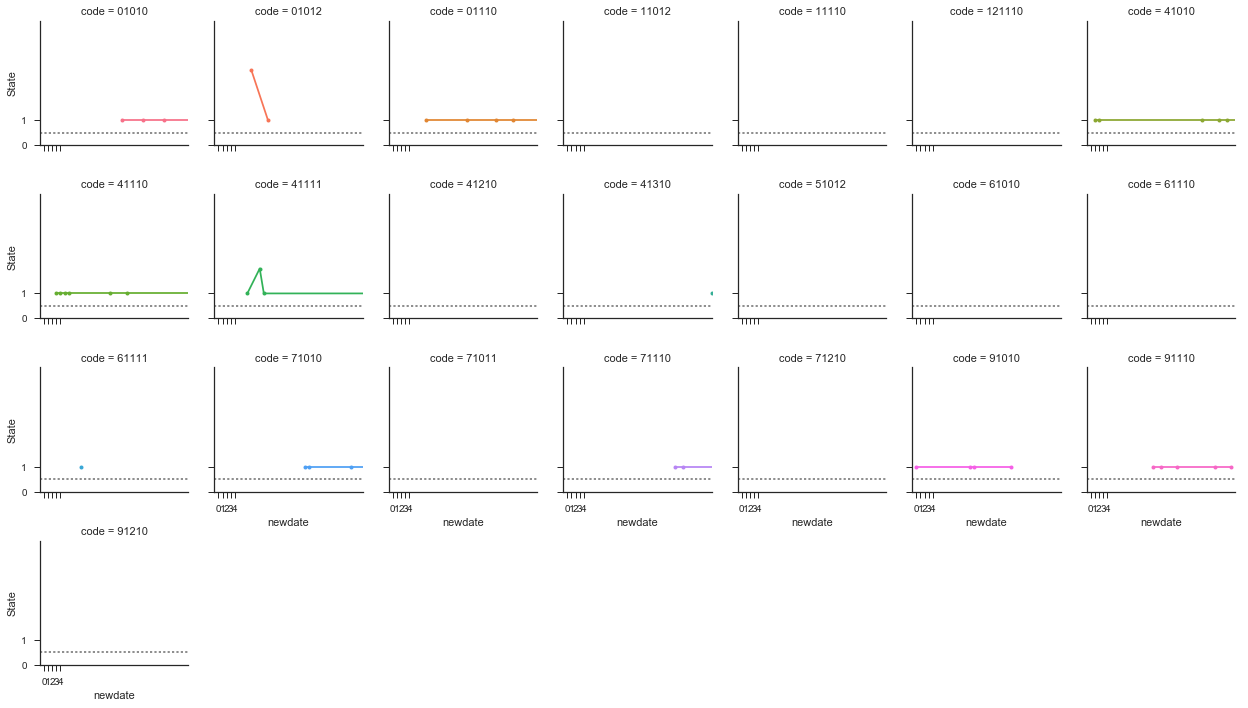

In [114]:
# Create a dataset with many short random walks
rs = np.random.RandomState(4)
pos = rs.randint(-1, 2, (20, 5)).cumsum(axis=1)
pos -= pos[:, 0, np.newaxis]
step = np.tile(range(5), 20)
walk = np.repeat(range(20), 5)

sns.set(style="ticks")
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(pvt1, col="code", hue="code", col_wrap=7, size=2.5)

# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=.5, ls=":", c=".5")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "newdate", "State", marker="o", ms=4)

# Adjust the tick positions and labels
#xlim is the date factorized
grid.set(xticks=np.arange(5), yticks=[0, 1],
         xlim=(-1, 35), ylim=(0, 5))

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1.15)



##### <b>Male Murders: Age Group 2 - 6 to 17</b>

In [132]:
def agedata(col):
    m1 = m_analyze.loc[(m_analyze['age_group'] == col)&(m_analyze['State'] == 'New York')]
    pvt = pd.pivot_table(m1,index=["Date_", "City", "code"],values=["State"],aggfunc=lambda x: len(x))
    pvt1 = pvt.reset_index()
    pvt1['newdate'] = pd.factorize(pvt1['Date_'])[0]
    #return pvt1

    # Create a dataset with many short random walks
    rs = np.random.RandomState(4)
    pos = rs.randint(-1, 2, (20, 5)).cumsum(axis=1)
    pos -= pos[:, 0, np.newaxis]
    step = np.tile(range(5), 20)
    walk = np.repeat(range(20), 5)

    sns.set(style="ticks")
    # Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(pvt1, col="code", hue="code", col_wrap=7, size=2.5)

    # Draw a horizontal line to show the starting point
    grid.map(plt.axhline, y=.5, ls=":", c=".5")

    # Draw a line plot to show the trajectory of each random walk
    grid.map(plt.plot, "newdate", "State", marker="o", ms=4)

    # Adjust the tick positions and labels
    #xlim is the date factorized
    grid.set(xticks=np.arange(5), yticks=[0, 1],
         xlim=(-1, 35), ylim=(0, 10))

    # Adjust the arrangement of the plots
    grid.fig.tight_layout(w_pad=1.15)

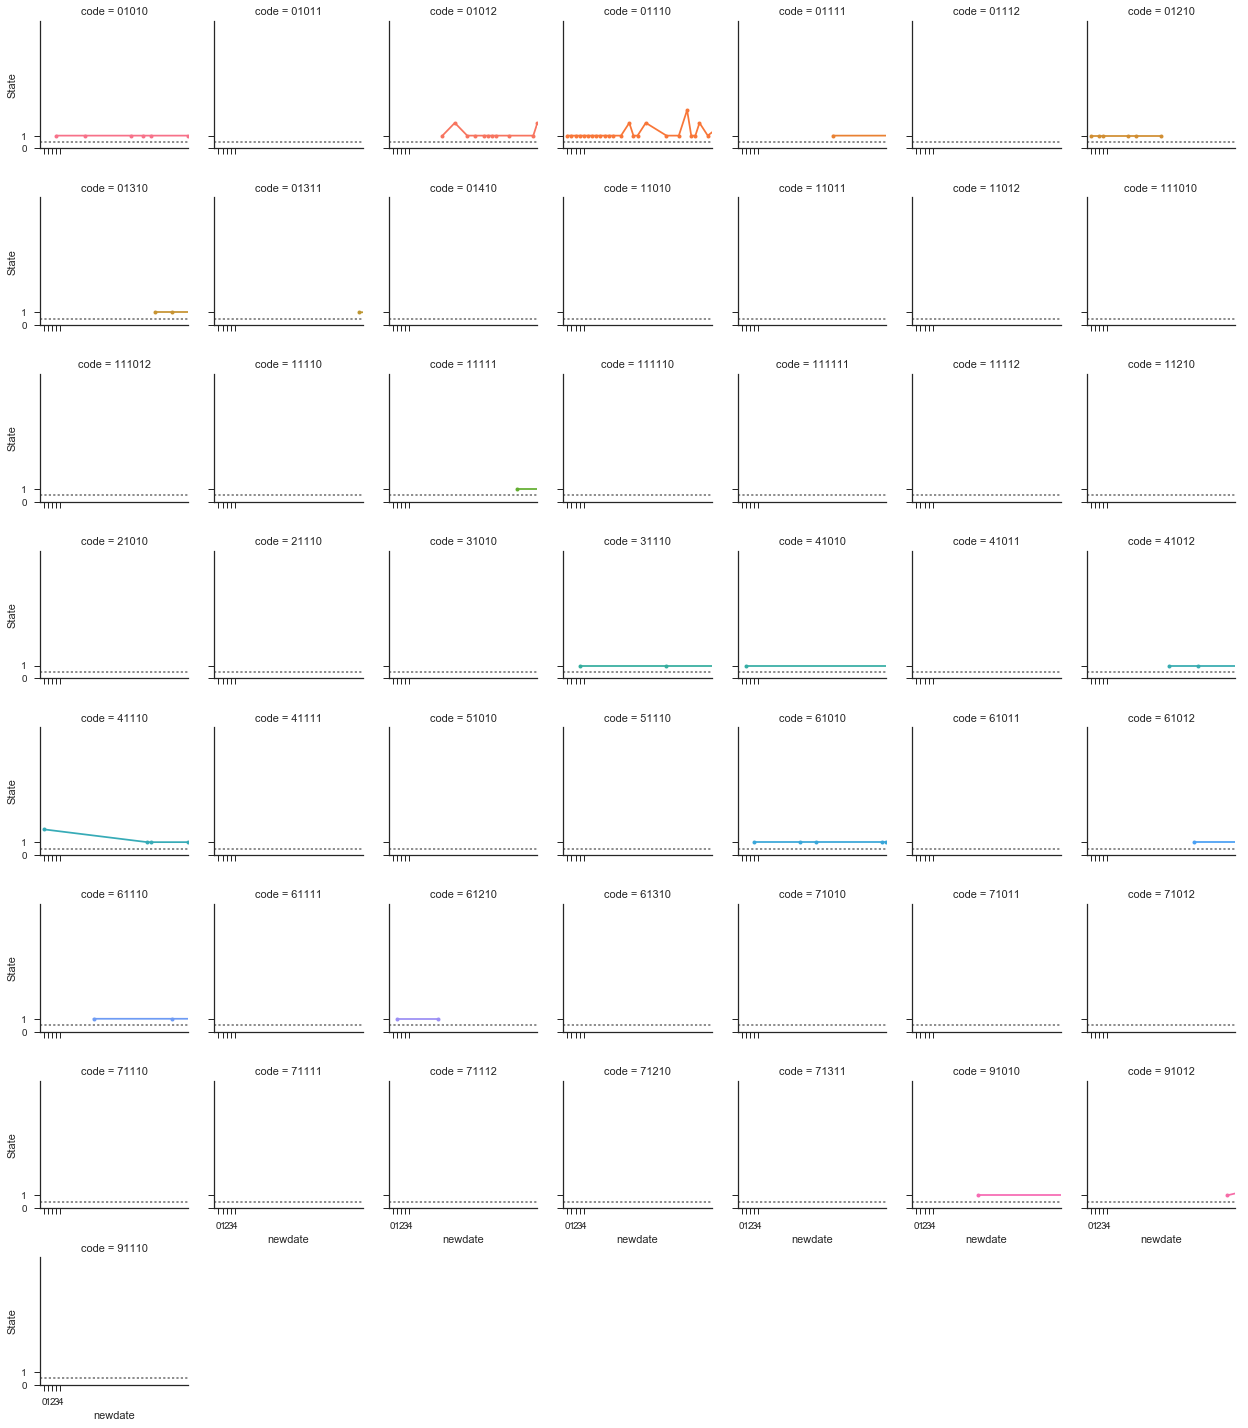

In [133]:
#Males 5 - 17 yo 
agedata('ag2')

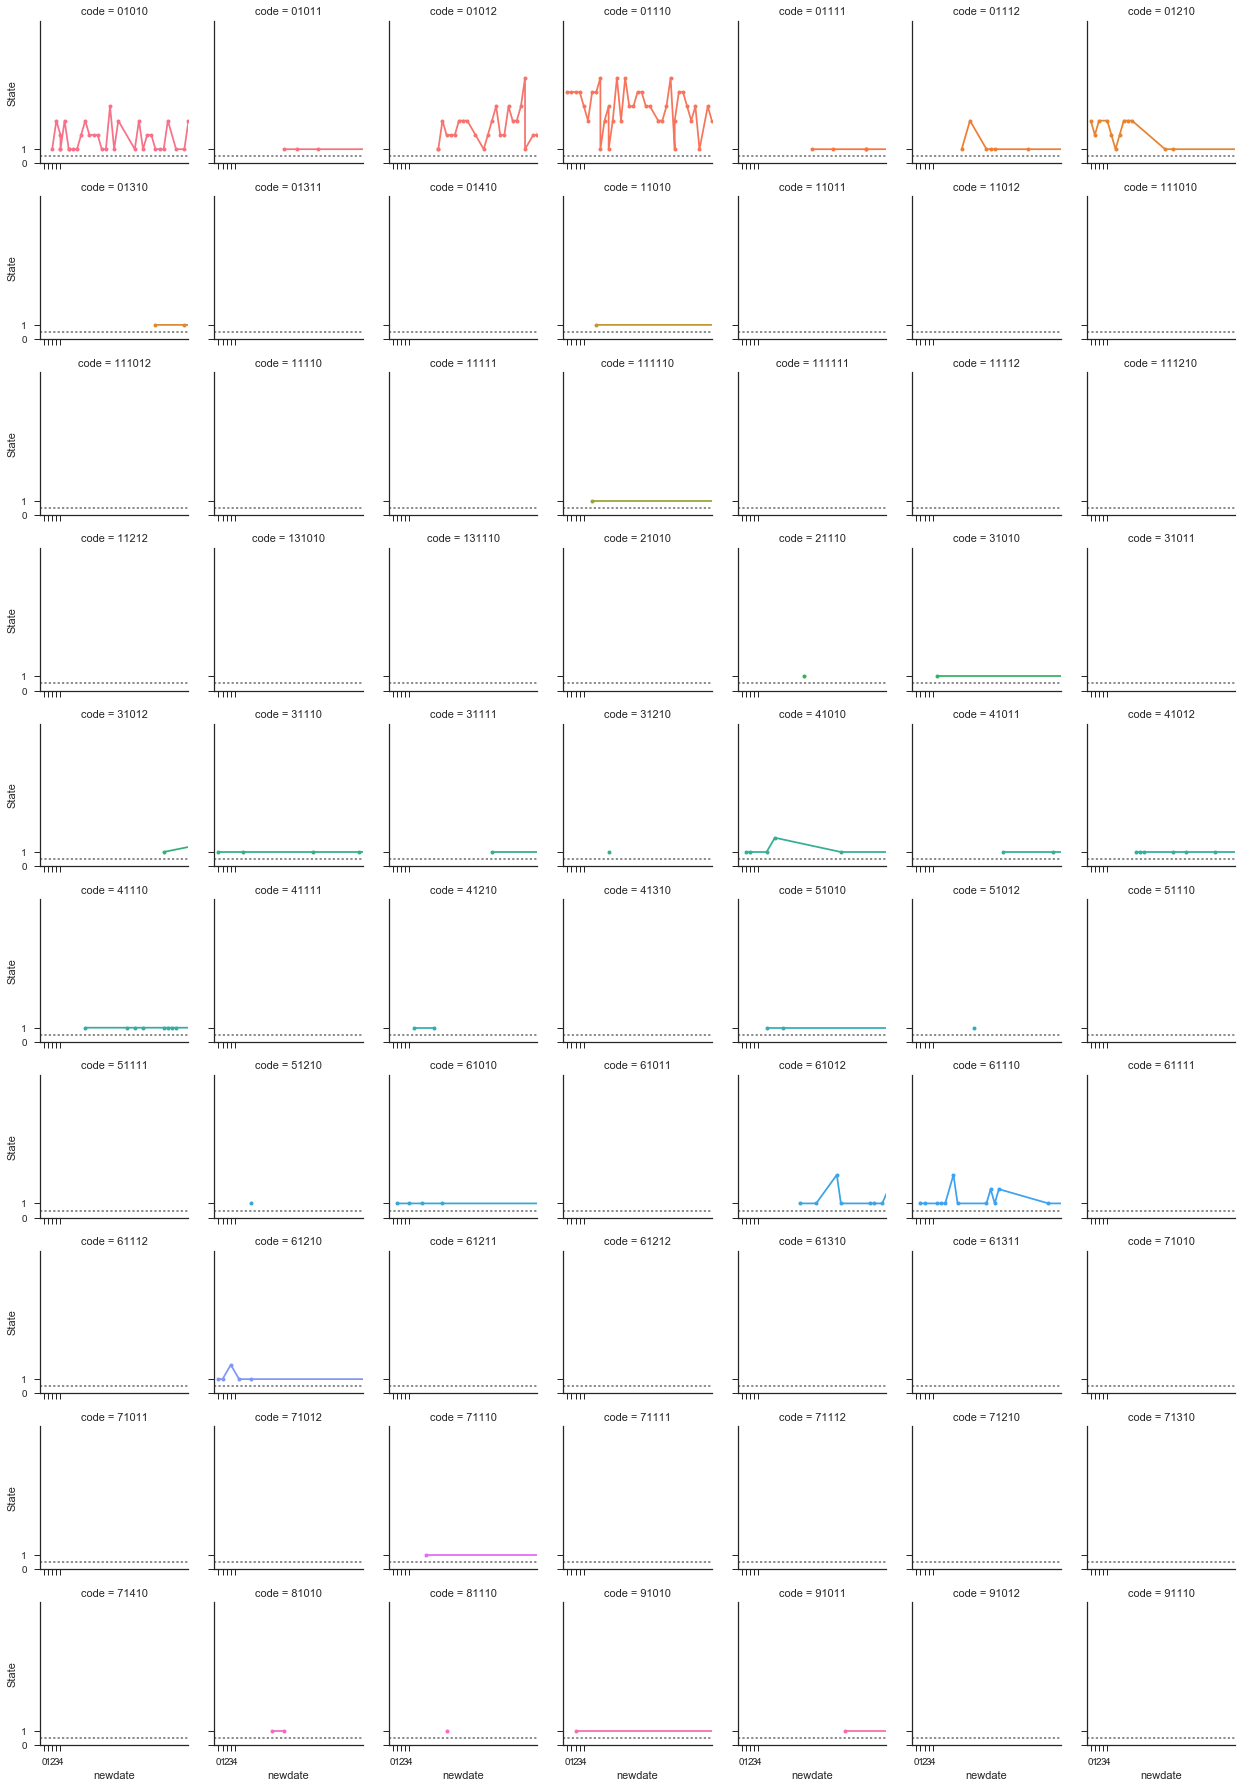

In [134]:
#Males 18 - 24
agedata('ag3')

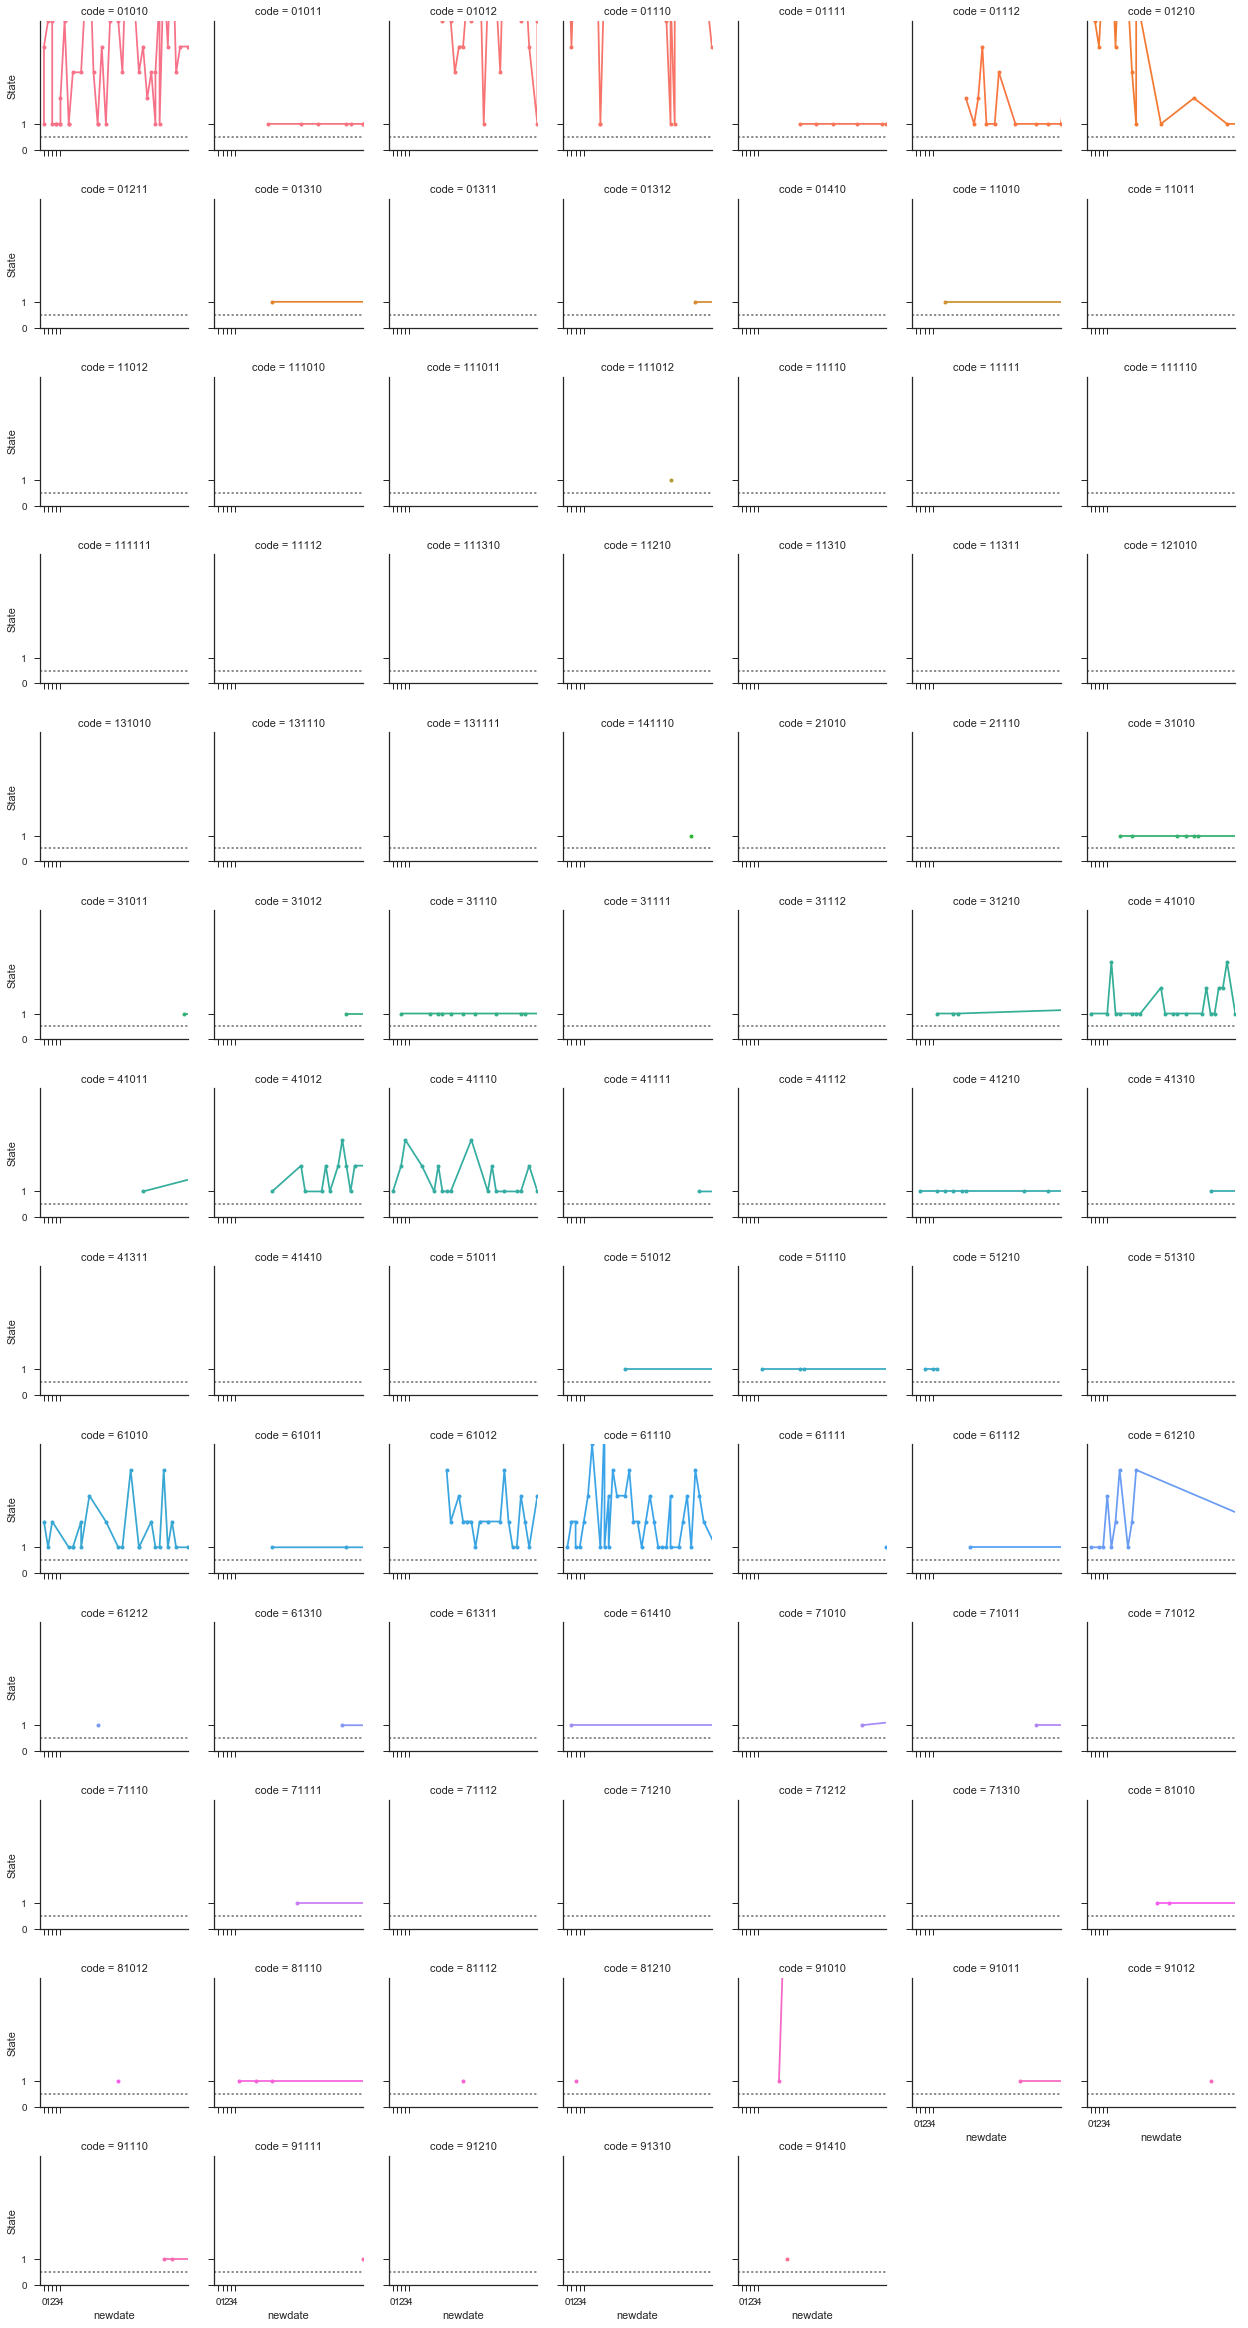

In [131]:
#Males 25 - 44
agedata('ag4')